In [41]:
%matplotlib inline  
import cv2
import numpy as np
from matplotlib import pyplot as plt

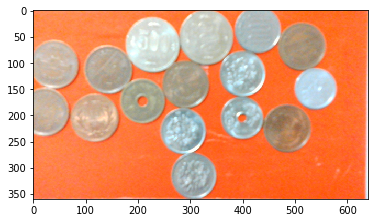

In [42]:
img = cv2.imread('./images/coin.png')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

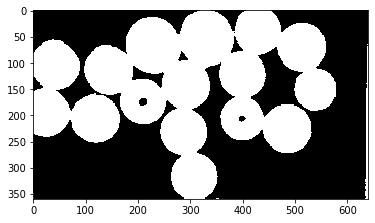

In [43]:
bgrLower = np.array([0, 0, 250])    # 抽出する色の下限(BGR)
bgrUpper = np.array([180, 180, 255])    # 抽出する色の上限(BGR)
img_mask = cv2.inRange(img, bgrLower, bgrUpper) # BGRからマスクを作成
bin_img = cv2.bitwise_not(img_mask)
plt.imshow(cv2.cvtColor(bin_img, cv2.COLOR_BGR2RGB))

find circle
[[398, 206], [208, 174]]


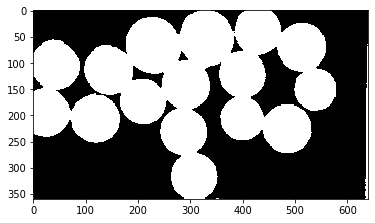

In [44]:
#5円,50円の穴埋め

hole_list = []
circles = cv2.HoughCircles(bin_img, cv2.HOUGH_GRADIENT, 1, 10, param1=8, param2=8, minRadius=0, maxRadius=10)
try:
    if (circles!=None).any():
        print("find circle")
        circles = np.uint16(np.around(circles))
        for i in circles[0,:]:
            cv2.circle(bin_img,(i[0],i[1]),i[2]*2,255,-1)
            hole_list.append([i[0],i[1]])
except:
    pass

plt.imshow(cv2.cvtColor(bin_img, cv2.COLOR_BGR2RGB))
print(hole_list)

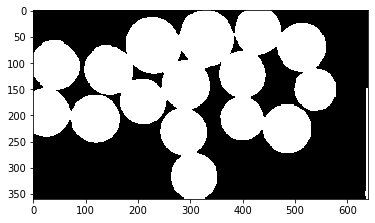

In [45]:
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(bin_img,cv2.MORPH_OPEN,kernel,iterations = 2)
plt.imshow(opening,cmap='gray')

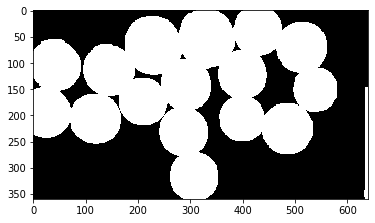

In [46]:
# モルフォロジー演算のDilationを使う
sure_bg = cv2.dilate(opening,kernel,iterations=2)
plt.imshow(sure_bg,cmap='gray')

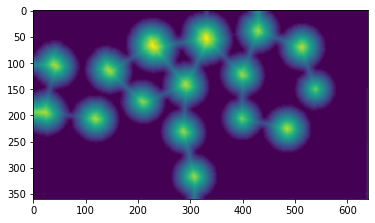

In [47]:
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
plt.imshow(dist_transform)

閾値（距離変換で得られた値の最大値×0.5）: 25.59845542907715


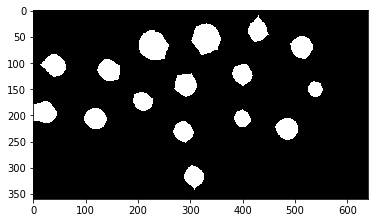

In [48]:
ret, sure_fg = cv2.threshold(dist_transform,0.5*dist_transform.max(),255,0)
print('閾値（距離変換で得られた値の最大値×0.5）:',ret)
plt.imshow(sure_fg,cmap='gray')

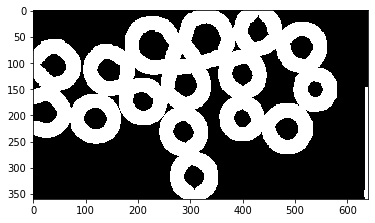

In [49]:
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)
plt.imshow(unknown,cmap='gray')

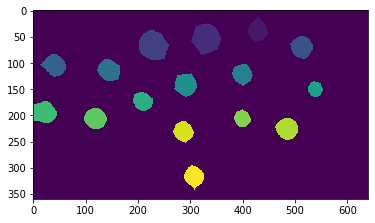

In [50]:
# foregroundの1オブジェクトごとにラベル（番号）を振っていく
ret, markers, stats, centroids  = cv2.connectedComponentsWithStats(sure_fg)
plt.imshow(markers)

In [51]:
# markersのデータの中をのぞいみている
print(np.unique(markers,return_counts=True))
print(centroids)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
      dtype=int32), array([208309,   1256,   2433,   2495,   1403,   1419,   1422,   1167,
         1447,    649,   1048,   1527,   1330,    791,   1371,   1151,
         1182], dtype=int64))
[[323.5119606  183.79658584]
 [429.12738854  38.32802548]
 [330.66707768  53.96711878]
 [229.43126253  67.52184369]
 [512.89237349  70.38916607]
 [ 40.77660324 104.83368569]
 [145.0443038  114.55696203]
 [399.76949443 122.00257069]
 [291.42156185 141.60469938]
 [538.97534669 150.31895223]
 [209.56870229 173.92080153]
 [ 20.95612312 194.67518009]
 [118.87142857 206.55413534]
 [399.27180784 206.37926675]
 [485.23997082 225.44201313]
 [287.19808862 231.18505647]
 [307.37986464 316.81979695]]


In [52]:
markers = markers+1
np.unique(markers,return_counts=True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17],
       dtype=int32),
 array([208309,   1256,   2433,   2495,   1403,   1419,   1422,   1167,
          1447,    649,   1048,   1527,   1330,    791,   1371,   1151,
          1182], dtype=int64))

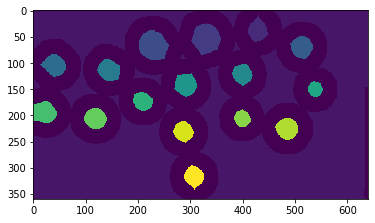

In [53]:
markers[unknown==255] = 0
plt.imshow(markers)

In [54]:
np.unique(markers,return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17], dtype=int32),
 array([ 93710, 114599,   1256,   2433,   2495,   1403,   1419,   1422,
          1167,   1447,    649,   1048,   1527,   1330,    791,   1371,
          1151,   1182], dtype=int64))

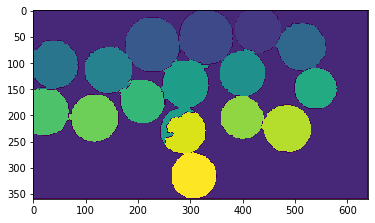

In [55]:
# "ヒント"であるmarkersをwatershedに適応する
markers = cv2.watershed(img,markers)
plt.imshow(markers)

In [56]:
label, counts = np.unique(markers,return_counts=True)
print(label, counts)

[-1  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] [  5817 124971   5785   8482   8412   6503   6401   6329   5943   7734
   4903   5507   5102   6467   5097   6464   4623   5860]


In [57]:
hole_coins = []

for i in range(len(hole_list)): 
    index = 0
    min_d = 10000
    for j in range(len(counts)-2):
        center = centroids[j+1]
        d = np.sqrt(pow((hole_list[i][0] - center[0]),2) + pow((hole_list[i][1] - center[1]),2))
        if min_d > d:
            min_d = d
            index = j+1
    hole_coins.append(index)
print(hole_coins)

[13, 10]


In [58]:
#ピクセル量閾値 5200以下:1円玉  8000以上:500円玉
#coin 100 と 10: blue > 150 で 100
one_coin_th = 5200
five_hundred_coin_th = 8000

coin = []

for i in range(len(counts)-2):
    center = centroids[i+1]
    count = counts[i+2]
    text = ""
    
    blue_avg = np.average(img[markers == i+2], axis = 0)[0]
    
    if hole_coins.count(i+1) > 0:
        if blue_avg > 150:
            text = "50"
            coin.append(50)
        else:
            text = "5"
            coin.append(5)
        
    elif count < one_coin_th:
        text = "1"
        coin.append(1)
    elif count > five_hundred_coin_th:
        text = "500"
        coin.append(500)
    else:
        if blue_avg > 150:
            text = "100"
            coin.append(100)
        else:
            text = "10"
            coin.append(10)
        
    size = 0.5
    cv2.putText(img, str(i+1), (int(center[0]), int(center[1]-20)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), thickness=2)
    cv2.putText(img, text, (int(center[0]), int(center[1])), cv2.FONT_HERSHEY_SIMPLEX, size, (0, 0, 0), thickness=2)
    
print(coin)

[100, 500, 500, 10, 100, 100, 100, 10, 1, 5, 1, 100, 50, 10, 1, 100]


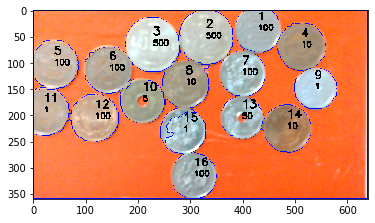

In [59]:
# 境界の領域を赤で塗る
img[markers == -1] = [255,0,0]
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [60]:
print(coin)
sum = 0
print("1円:", coin.count(1))
sum += coin.count(1) * 1
print("5円:", coin.count(1))
sum += coin.count(5) * 5
print("10円:", coin.count(10))
sum += coin.count(10) * 10
print("50円:", coin.count(1))
sum += coin.count(50) * 50
print("100円:", coin.count(100))
sum += coin.count(100) * 100
print("500円:", coin.count(500))
sum += coin.count(500) * 500
print("計:", sum, "円")

[100, 500, 500, 10, 100, 100, 100, 10, 1, 5, 1, 100, 50, 10, 1, 100]
1円: 3
5円: 3
10円: 3
50円: 3
100円: 6
500円: 2
計: 1688 円
